In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import itertools

# Extended Kalman Filter
The problem involves tracking a moving pedestrian from our moving vehicle using Lidar and Radar measurements that arrive asynchronously. An extended Kalman filter is to be used as we will see that the Radar measurement model is non-linear.

# Linear Motion Model
Assuming a time increment $\Delta t$ between state updates, the state transition model is given by
\begin{equation*}
\begin{bmatrix} x[k] \\ y[k] \\ v_x[k] \\ v_y[k] \end{bmatrix} = 
\begin{bmatrix} 1&0&\Delta t&0 \\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}
\begin{bmatrix}x[k-1] \\ y[k-1] \\ v_x[k-1] \\ v_y[k-1]\end{bmatrix}+
\begin{bmatrix}w_x \\ w_y \\ w_{vx} \\ w_{vy}\end{bmatrix}
\end{equation*}
This can be written succinctly as $X[k] = FX[k-1] + W[k]$. The uncertainty in velocity comes from unknown acceleration. If the lateral and longitudinal accelerations are $a_x$ and $a_y$ during a given time instant, then
\begin{equation*}
W = \begin{bmatrix} a_x\frac{\Delta t^2}{2} \\ a_y\frac{\Delta t^2}{2} \\ a_x\Delta t \\ a_y \Delta t\end{bmatrix} = 
\begin{bmatrix} \frac{\Delta t^2}{2}&0\\0&\frac{\Delta t^2}{2}\\\Delta t &0\\0&\Delta t\end{bmatrix} \begin{bmatrix}a_x & a_y\end{bmatrix}= Ga
\end{equation*}
# Process Noise
The covariance of the process noise can be derived as follows:
\begin{equation*}
Q = E[WW^T] = GE(aa^T)G^T =G\begin{bmatrix}\sigma_{ax}^2&0\\0&\sigma_{ay}^2\end{bmatrix}G^T = 
\begin{bmatrix}\frac{\Delta t^4}{4}\sigma_{ax}^2&0&\frac{\Delta t^3}{2}\sigma_{ax}^2&0\\
0&\frac{\Delta t^4}{4}\sigma_{ay}^2&0&\frac{\Delta t^3}{2}\sigma_{ay}^2\\
\frac{\Delta t^3}{2}\sigma_{ax}^2&0&\Delta t^2\sigma_{ax}^2&0\\
0&\frac{\Delta t^3}{2}\sigma_{ay}^2&0&\Delta t^2\sigma_{ay}^2\\
\end{bmatrix}
\end{equation*}
This assumes the lateral and longitudinal components of the acceleration are uncorrelated and the variances $(\sigma_{ax}^2,\sigma_{ay}^2)$ have been estimated. Since the motion model is linear, normal kalman filter equations can be applied for the prediction step. The prediction steps are given by
\begin{eqnarray*}
\hat{X}[k] = FX[k-1]\\
P = FP_{k-1}F^T+Q
\end{eqnarray*}



# Lidar Measurement Model
A simplified model is assumed wherein the pedestrian position in cartesian coordinates can be measured subject to measurement noise, i.e.,
$Z[k] = HX[k]+ V[k]$. The measurement matrix is then given by
\begin{equation*}
H = \begin{bmatrix} 1&0&0&0 \\ 0&1&0&0\end{bmatrix}
\end{equation*}
The measurement noise covariance is given by 
\begin{equation*}
R = \begin{bmatrix} \sigma_{x}^2&0 \\ 0&\sigma_{y}^2 \end{bmatrix}
\end{equation*}
After we receive an observation $Z[k]$ we correct our prediction as follows
\begin{eqnarray*}
&X[k] = \hat{X}[k] + K(Z[k]-H\hat{X}[k])\\
&K = PH^T(HPH^T+R)^{-1}\\
&P_k = (I_{4x4}-KH)P
\end{eqnarray*}

# Radar Measurement Model
The radar is assumed to provide the 3-tuple (radial distance, bearing angle, radial velocity). We can denote this as $(\rho,\phi,\dot{\rho})$. Since the measurements $Z[n]$ are in polar coordinates, a non-linear function $h$ is needed to map from the state $X[k]$. This is given by
\begin{equation*}
\begin{bmatrix}\rho \\ \phi \\\dot{\rho}\end{bmatrix} = h(X[k]) = \begin{bmatrix} \sqrt{x^2[k]+y^2[k]} \\ atan2(\frac{y[k]}{x[k]}) \\ \frac{x[k]v_x[k]+y[k]v_y[k]}{\sqrt{x^2[k]+y^2[k]}} \end{bmatrix}
\end{equation*}
Since the state-to-measurement function is non-linear, we can correct our prediction using Extended Kalman Filter as follows
\begin{eqnarray*}
&X[k] = \hat{X}[k] + K(Z[k]-h(\hat{X}[k]))\\
&K = PH_j^T(H_jPH_j^T+R)^{-1}\\
&P_n = (I_{4x4}-KH_j)P,
\end{eqnarray*}
where $H_j$ is the Jacobian of $h(\cdot)$ evaluated at the predicted state $\hat{X}[k] = (\hat{x}[k],\hat{y}[k],\hat{v_x}[k],\hat{v_y}[k])^T$. $H_j$ is then given by
\begin{equation*}
H_j =  \frac{1}{\sqrt{\hat{x}^2[k]+\hat{y}^2[k]}}\begin{bmatrix}\hat{x}[k]&\hat{y}[k]&0&0\\
-\hat{y}[k]&\hat{x}[k]&0&0\\
\frac{\hat{y}[k](\hat{y}[k]\hat{v_x}[k]-\hat{x}[k]\hat{v_y}[k])}{\hat{x}^2[k]+\hat{y}^2[k]} & \frac{\hat{x}[k](\hat{x}[k]\hat{v_y}[k]-\hat{y}[k]\hat{v_x}[k])}{\hat{x}^2[k]+\hat{y}^2[k]} &\hat{x}[k]&\hat{y}[k]\end{bmatrix}
\end{equation*}

# Data File Format
Each row represents a sensor measurement where the first column tells you if the measurement comes from radar (R) or lidar (L).

For a row containing radar data, the columns are: sensor_type, rho_measured, phi_measured, rhodot_measured, timestamp, x_groundtruth, y_groundtruth, vx_groundtruth, vy_groundtruth, yaw_groundtruth, yawrate_groundtruth.

For a row containing lidar data, the columns are: sensor_type, x_measured, y_measured, timestamp, x_groundtruth, y_groundtruth, vx_groundtruth, vy_groundtruth, yaw_groundtruth, yawrate_groundtruth

Ground truth for yaw and Yaw rate are to be used only for the Unscented Kalman filter. It is ignored here.

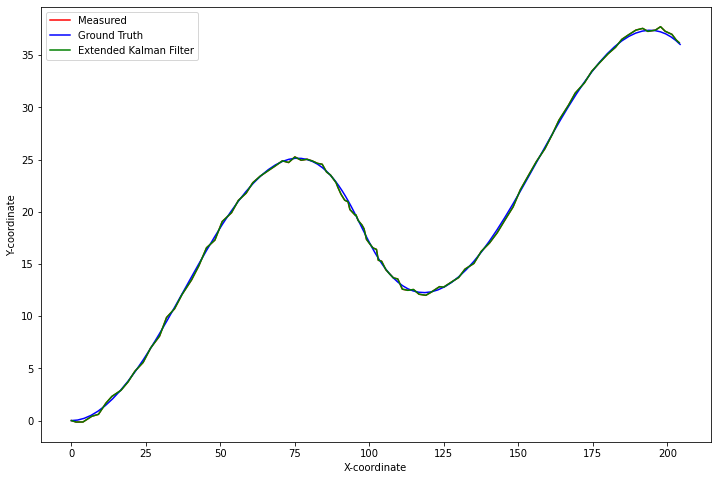

Kalman filter: RMSE in x position= 0.21801444425555022
Kalman filter: RMSE in y position= 0.1943251918477005
Kalman filter: RMSE in vx= 0.9387329927207112
Kalman filter: RMSE in vy= 0.8359153334954099
Measured: RMSE in x position= 0.21949067383907134
Measured: RMSE in y position= 0.1961188135293539


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import itertools


#Process noise parameters
sigma_ax2 = 9
sigma_ay2 = 9
#Measurement noise parameters: Lidar
sigma_x2 = 0.0225
sigma_y2 = 0.0225
#Measurement noise parameters: Radar
sigma_rho2 = 0.09
sigma_phi2 = 0.0009
sigma_rhodot2 = 0.09

useLidar = True
useRadar = False

#initialization
P = np.asarray([[10,0,0,0],[0,10,0,0],[0,0,100,0],[0,0,0,100]])
X = np.asarray([[1],[1],[1],[0.0]])

def Polar2Cartesian(arr):
    rho = arr[0]
    angle = arr[1]
    return rho*np.cos(angle),rho*np.sin(angle)

def RMSE(x,xprime):
    return np.linalg.norm(np.asarray(x)-np.asarray(xprime))/np.sqrt(len(x))

#Linear Motion Model
def Fmatrix(dt):
    return np.asarray([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])
#Process covariance
def Q(dt):
    q = np.asarray([[sigma_ax2*dt**4/4,0,sigma_ax2*dt**3/2,0],[0,sigma_ay2*dt**4/4,0,sigma_ay2*dt**3/2],
                  [sigma_ax2*dt**3/2,0,sigma_ax2*dt**2,0],[0,sigma_ay2*dt**3/2,0,sigma_ay2*dt**2]])
    
    return q

#Lidar
#observes only position
HLidar = np.asarray([[1,0,0,0],[0,1,0,0]])
#noise covariance
RLidar = np.asarray([[sigma_x2,0],[0,sigma_y2]]) 

#Radar
def HRadar(state):
    x,y,vx,vy = state
    return np.asarray([[math.sqrt(x**2+y**2)],[math.atan2(y,x)],[(x*vx+y*vy)/math.sqrt(x**2+y**2)]])
#noise covariance

RRadar = np.asarray([[sigma_rho2,0,0],[0,sigma_phi2,0],[0,0,sigma_rhodot2]]) 

def HJacobian(state):
    x,y,vx,vy = tuple(np.concatenate(state))
    t1 = np.sqrt(x**2+y**2)
    t2 = y*(y*vx-x*vy)/(t1**3)
    t3 = x*(x*vy-y*vx)/(t1**3)
    if t1 > 1e-3:
        return np.asarray([[x/t1,y/t1,0,0],[-y/(t1**2),x/(t1**2),0,0],[t2,t3,x/t1,y/t1]])
    else:
        return np.zeros([3,4])
    
data=[]
sensortype=[]
#DataFile = open("./obj_pose-laser-radar-synthetic-input.txt","r+")
#DataFile = open("./data/sample-laser-radar-measurement-data-1.txt","r+")
DataFile = open("./data/sample-laser-radar-measurement-data-2.txt","r+")
for row in DataFile.readlines():
    curRow = []
    if row.split()[0] == 'L':
        sensortype.append("L")
    elif row.split()[0] == 'R':
        sensortype.append("R")
    data.append([float(i) for i in row.split()[1:]])

xpos=[]
ypos=[]
xpos_gt=[]
ypos_gt=[]
xpos_measured=[]
ypos_measured = []
vx=[]
vy=[]
vx_gt=[]
vy_gt=[]
vx_measured = []
vy_measured = []
#prev_timestamp = 1477010442500000.0
prev_timestamp = 1477010443299637 #sample file 2
Radarstates=3
Lidarstates=2

k = 0
alpha = 1.001



for i,Z in enumerate(data): 
    Lidar = (sensortype[i]=='L')
    k = k+1
    if Lidar:
        if useLidar:
            dt = (Z[2] - prev_timestamp)/1000000.0
            prev_timestamp = Z[2]
            xpos_gt.append(Z[3])
            ypos_gt.append(Z[4])
            vx_gt.append(Z[5])
            vy_gt.append(Z[6])
            xpos_measured.append(Z[0])
            ypos_measured.append(Z[1])
        else:
            continue
    else:
        if useRadar:
            dt = (Z[3] - prev_timestamp)/1000000.0
            prev_timestamp = Z[3]
            xpos_gt.append(Z[4])
            ypos_gt.append(Z[5])
            vx_gt.append(Z[6])
            vy_gt.append(Z[7])
            xt,yt = Polar2Cartesian(Z[0:2])
            xpos_measured.append(xt)
            ypos_measured.append(yt)
            vx_measured.append(Z[2]*np.cos(Z[1]))
            vy_measured.append(Z[2]*np.sin(Z[1]))
        else:
            continue
            
    
    
            
   #Prediction step
    F = Fmatrix(dt)
    X = np.matmul(F,X)
    P = np.add(np.matmul(np.asarray(np.matmul(F,P)),np.transpose(F)),Q(dt))

    
    #Update step
    if Lidar:
        S=np.matmul(np.matmul(HLidar,P),np.transpose(HLidar))+RLidar   #temporary variable for next step
        K = np.dot(np.matmul(P,np.transpose(HLidar)),np.linalg.inv(S))
        #K=np.zeros([4,2])
        y=np.reshape(np.asarray(Z[0:2]),(Lidarstates,1))-np.matmul(HLidar,X)
        X = np.add(X,np.dot(K,y))
        #X=np.reshape(np.asarray([Z[0],Z[1],0,0]),(4,1))
        P = np.matmul(np.identity(4)-np.matmul(K,HLidar),P)
        xpos.append(X[0])
        ypos.append(X[1])
        vx.append(X[2])
        vy.append(X[3])
    
        
    else:
        Hj = HJacobian(X)
        S=np.matmul(np.dot(Hj,P),np.transpose(Hj))+RRadar 
        K = np.dot(np.dot(P,np.transpose(Hj)),np.linalg.inv(S))
        #K=np.zeros([4,3])
        y = np.reshape(np.asarray(Z[0:3]),(Radarstates,1))-HRadar(X)
        if y[1] > np.pi:
            y[1] = y[1]-2*np.pi
        elif y[1] < -np.pi:
            y[1] = y[1]+2*np.pi
        X = np.add(X,np.dot(K,y))
        #X=np.reshape(np.asarray([Z[0]*np.cos(Z[1]),Z[0]*np.sin(Z[1]),Z[2]*np.cos(Z[1]),Z[2]*np.sin(Z[1])]),(4,1))
        P = np.dot(np.identity(4)-np.dot(K,Hj),P)
        
        
        #print(i,X[0],X[1])
        xpos.append(X[0])
        ypos.append(X[1])
        vx.append(X[2])
        vy.append(X[3])
        
        
#print(type(xpos))
xpos = list(itertools.chain.from_iterable(xpos))
ypos = list(itertools.chain.from_iterable(ypos))
vx = list(itertools.chain.from_iterable(vx))
vy = list(itertools.chain.from_iterable(vy))

plt.figure(figsize=(12,8))
plt.plot(xpos_measured,ypos_measured,label='Measured',color='r')
plt.plot(xpos_gt,ypos_gt,label='Ground Truth',color='b')
plt.plot(xpos,ypos,label='Extended Kalman Filter',color='g')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.savefig('EKF.png',bbox_inches='tight')
plt.show()

print("Kalman filter: RMSE in x position=",RMSE(xpos,xpos_gt))
print("Kalman filter: RMSE in y position=",RMSE(ypos,ypos_gt))
print("Kalman filter: RMSE in vx=",RMSE(vx,vx_gt))
print("Kalman filter: RMSE in vy=",RMSE(vy,vy_gt))

print("Measured: RMSE in x position=",RMSE(xpos_measured,xpos_gt))
print("Measured: RMSE in y position=",RMSE(ypos_measured,ypos_gt))

Results with Exponential weighted EKF
----------------------------------------
Kalman filter: RMSE in x position= 0.21763676505941945
Kalman filter: RMSE in y position= 0.19462364917491864
Kalman filter: RMSE in vx= 0.5145314887287956
Kalman filter: RMSE in vy= 0.46249880848289066
Measured: RMSE in x position= 0.21949067383907134
Measured: RMSE in y position= 0.1961188135293539


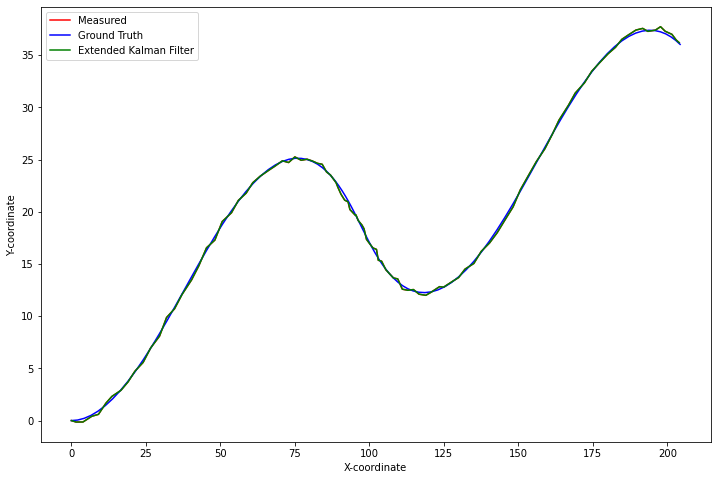

In [3]:
################################################

# Exponentially Weighted EKF

#################################################


import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import itertools


#Process noise parameters
sigma_ax2 = 9
sigma_ay2 = 9
#Measurement noise parameters: Lidar
sigma_x2 = 0.0225
sigma_y2 = 0.0225

'''
#Measurement noise parameters: Radar
sigma_rho2 = 0.09
sigma_phi2 = 0.0009
sigma_rhodot2 = 0.09
useRadar = False
'''

useLidar = True


#initialization
P = np.asarray([[10,0,0,0],[0,10,0,0],[0,0,100,0],[0,0,0,100]])
X = np.asarray([[1],[1],[1],[0.0]])



def RMSE(x,xprime):
    return np.linalg.norm(np.asarray(x)-np.asarray(xprime))/np.sqrt(len(x))

#Linear Motion Model
def Fmatrix(dt):
    return np.asarray([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])
#Process covariance
def Q(dt):
    return np.asarray([[sigma_ax2*dt**4/4,0,sigma_ax2*dt**3/2,0],[0,sigma_ay2*dt**4/4,0,sigma_ay2*dt**3/2],
                  [sigma_ax2*dt**3/2,0,sigma_ax2*dt**2,0],[0,sigma_ay2*dt**3/2,0,sigma_ay2*dt**2]])
    

#Lidar
#observes only position
HLidar = np.asarray([[1,0,0,0],[0,1,0,0]])
#noise covariance
RLidar = np.asarray([[sigma_x2,0],[0,sigma_y2]]) 


    
data=[]
sensortype=[]
#DataFile = open("./obj_pose-laser-radar-synthetic-input.txt","r+")
#DataFile = open("./data/sample-laser-radar-measurement-data-1.txt","r+")
DataFile = open("./data/sample-laser-radar-measurement-data-2.txt","r+")
for row in DataFile.readlines():
    curRow = []
    if row.split()[0] == 'L':
        sensortype.append("L")
    elif row.split()[0] == 'R':
        sensortype.append("R")
    data.append([float(i) for i in row.split()[1:]])

xpos=[]
ypos=[]
xpos_gt=[]
ypos_gt=[]
xpos_measured=[]
ypos_measured = []
vx=[]
vy=[]
vx_gt=[]
vy_gt=[]
vx_measured = []
vy_measured = []
#prev_timestamp = 1477010442500000.0
prev_timestamp = 1477010443299637 #sample file 2
Lidarstates=2

alpha = 1.005
#alpha = float(input("Enter Alpha value"))


for i,Z in enumerate(data): 
    Lidar = (sensortype[i]=='L')
    
    if Lidar:
        if useLidar:
            dt = (Z[2] - prev_timestamp)/1000000.0
            prev_timestamp = Z[2]
            xpos_gt.append(Z[3])
            ypos_gt.append(Z[4])
            vx_gt.append(Z[5])
            vy_gt.append(Z[6])
            xpos_measured.append(Z[0])
            ypos_measured.append(Z[1])
    else:
        continue


    #Prediction step
    F = Fmatrix(dt)
    X = np.matmul(F,X)
    P = P*alpha**(2*i)
    P = np.add(np.matmul(np.asarray(np.matmul(F,P)),np.transpose(F)) * alpha**2,Q(dt) * alpha**(-2*(i+1)))

        
        #Update step
    if Lidar:
        S=np.matmul(np.matmul(HLidar,P),np.transpose(HLidar))+ RLidar/(alpha**2)   #temporary variable for next step
        K = np.dot(np.matmul(P,np.transpose(HLidar)),np.linalg.inv(S))
        #K=np.zeros([4,2])
        y=np.reshape(np.asarray(Z[0:2]),(Lidarstates,1))-np.matmul(HLidar,X)
        X = np.add(X,np.dot(K,y))
        #X=np.reshape(np.asarray([Z[0],Z[1],0,0]),(4,1))
        P = np.matmul(np.identity(4)-np.matmul(K,HLidar),P)
        xpos.append(X[0])
        ypos.append(X[1])
        vx.append(X[2])
        vy.append(X[3])
        
    
        
        
#print(type(xpos))
xpos = list(itertools.chain.from_iterable(xpos))
ypos = list(itertools.chain.from_iterable(ypos))
vx = list(itertools.chain.from_iterable(vx))
vy = list(itertools.chain.from_iterable(vy))


print("Results with Exponential weighted EKF")
print("----------------------------------------")
print("Kalman filter: RMSE in x position=",RMSE(xpos,xpos_gt))
print("Kalman filter: RMSE in y position=",RMSE(ypos,ypos_gt))
print("Kalman filter: RMSE in vx=",RMSE(vx,vx_gt))
print("Kalman filter: RMSE in vy=",RMSE(vy,vy_gt))

print("Measured: RMSE in x position=",RMSE(xpos_measured,xpos_gt))
print("Measured: RMSE in y position=",RMSE(ypos_measured,ypos_gt))



plt.figure(figsize=(12,8))
plt.plot(xpos_measured,ypos_measured,label='Measured',color='r')
plt.plot(xpos_gt,ypos_gt,label='Ground Truth',color='b')
plt.plot(xpos,ypos,label='Extended Kalman Filter',color='g')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.savefig('EKF.png',bbox_inches='tight')
plt.show()

# Unscented Kalman Filter

The problem stated above is to be solved using EKF. A non-linear transformation of a Gaussian distribution will no longer be Gaussian. EKF overcomes this by approximating the non-linear function to being linear around the last-estimated/ predicted state. Instead of the linearizing approach, which may not be valid for large non-linearities, UKF approximates the resulting distribution itself. The non-linear function is left intact. 

Next we look at a state transition model that is non-linear and better explains curvilinear motion.

# Constant turn rate and velocity magnitude model
In order to model vehicles that turn, state vector used is $X[k] = {x[k],y[k],v[k],\psi[k], \dot{\psi}[k]}$. $\psi$ and $\dot{\psi}$ indicate yaw angle and yaw angle rate change, respectively. Since the model assumes constant yaw rate $\omega$, the rate of change of the state is given by
\begin{equation*}
\dot{X} = \begin{bmatrix}\dot{x}\\ \dot{y}\\ \dot{v} \\ \dot{\psi} \\ \ddot{\psi} \end{bmatrix} =
\begin{bmatrix}vcos(\psi)\\ vsin(\psi) \\ 0 \\ \omega \\ 0\end{bmatrix}
\end{equation*}
This can be used to discretize the state transition as follows
\begin{equation*}
X[k+1] = X[k] + \begin{bmatrix}\frac{v[k]}{\omega[k]}(sin(\psi[k]+\omega[k]\Delta t)-sin(\psi[k]))\\
\frac{v[k]}{\omega[k]}(-cos(\psi[k]+\omega[k]\Delta t)+cos(\psi[k]))\\
0 \\ \omega[k]\Delta t \\ 0 \end{bmatrix}
\end{equation*}
The special case of straight-line motion, i.e., $\omega = 0$ can be handled separately.

# Process Noise
The stochasticity in this model is assumed to arise from unknown longitudinal and yaw accelerations. Say, the variances of these two components are $\sigma_{ax}^2$ and $\sigma_{\ddot{\psi}}^2$. In a given time instant, the process noise samples are $\nu_{a}$ and $\nu_{\ddot{\psi}}$. Then the state transition can be rewritten as
\begin{equation*}
X[k+1] = X[k] + \begin{bmatrix}\frac{v[k]}{\omega[k]}(sin(\psi[k]+\omega[k]\Delta t)-sin(\psi[k]))\\
\frac{v[k]}{\omega[k]}(-cos(\psi[k]+\omega[k]\Delta t)+cos(\psi[k]))\\
0 \\ \omega[k]\Delta t \\ 0 \end{bmatrix} +
\begin{bmatrix} \nu_{a}cos(\psi[k])\frac{\Delta t^2}{2} \\ \nu_{a}sin(\psi[k])\frac{\Delta t^2}{2} \\ \nu_{a}\Delta t \\ \nu_{\ddot{\psi}}\frac{\Delta t^2}{2}\\ \nu_{\ddot{\psi}}\Delta t\end{bmatrix}
\end{equation*}
Notice that the process noise has a non-linear effect on state transition. In order to use the UKF framework, the state is augmented to include the process noise as $X_a = \begin{bmatrix} x & y & v& \psi & \dot{\psi} & \nu_{a} & \nu_{\ddot{\psi}}\end{bmatrix}^T$. In other words, $X[k+1] = f(X_a[k])$ where $f$ denotes the non-linear transformation. The uncertainty in the estimation of this augmented state can then be expressed as
\begin{equation*}
P_a = \begin{bmatrix} P &0 \\ 0 &Q\end{bmatrix}
\end{equation*}
Here $P$ describes the current estimate of the error ellipse, while $Q$ is the diagonal matrix with entries $(\sigma_{a}^2$ , $\sigma_{\ddot{\psi}}^2)$. 

# Sigma point generation
In addition to the mean (i.e, the predicted/ estimated state), $2n$ points are selected, where $n$ is the dimensionality of the state. Each selected point has a specific weight. The $2n+1$ points are collectively referred to as "Sigma points". Each of the point is transformed through the non-linear function. The weighted mean and covariance is then computed. The transformed distribution is then approximated as Gaussian with this computed mean and covariance. In time step $k$ the sigma points are chosen as follows
\begin{eqnarray*}
\chi^{[0]} &=& X[k] \\
\chi^{[i]} &=& X[k] + (\sqrt{(\lambda+n)P_a})_i \; i=1,2,\cdots,n \\
\chi^{[i]} &=& X[k] - (\sqrt{(\lambda+n)P_a})_{i-n} \; i=n+1,n+2,\cdots,2n 
\end{eqnarray*}
$X[k]$ is the predicted state. $\lambda$ is a scaling parameter that can control the spread across sigma points. $(P_a)_i$ is the covariance matrix of the augmented state. There are 2 matrix notations introduced here

(a) $(A)_i$ is the $i$th column of matrix $A$

(b) $\sqrt{A}$ refers to matrix square root. For ease of computation, this would be the matrix $S$ such that $A = SS^T$. This in turn is given by Cholesky decomposition of $A = VDV^{-1}$, where $D$ is a diagonal matrix with $d_i$ for $i=1,2,\cdots,n+2$ as its entries. Then $S=V\bar{D}V^{-1}$, where $\bar{D}$ is a diagonal matrix with entries $\sqrt{d_i}$ as its entries

The weights for each point are taken to be
\begin{eqnarray*}
w^{[0]} &=& \frac{\lambda}{n+\lambda} \\
w^{[i]} &=& \frac{1}{2(n+\lambda)}
\end{eqnarray*}
Then the weighted mean and covariance can be calculated as
\begin{eqnarray*}
\hat{X}[k] &=& \sum_i{w^{[i]}f(\chi^{[i]})} \\
P &=& \sum_i{w^{[i]}(f(\chi^{[i]})-\hat{X}[k])(f(\chi^{[i]})-\hat{X}[k])^T}
\end{eqnarray*}
This gives the predicted state and the uncertainty in state prediction. Note that different weights have been used for mean and covariance calculations in literature.

# Measurement model

In order to compare with the received measurement, we need to first predict the measurement. For Lidar, regular Kalman filter equations can be used. On the other hand, the measurement function is non-linear for the Radar. So we will apply an unscented transform as in the process model. This would imply sigma points have to be generated using the predicted mean and covariance, namely $[\hat{X}[k] \; X[k]\pm\gamma\sqrt{P}]$ for some scaling factor $\gamma$. One popular short-cut is to skip generating sigma points again and simply re-use the transformed sigma points $f(\chi^{[i]})$. In addition, the measurement noise has only an additive effect, so the state space need not be augmented. Let $Z^{[i]} = h(f(\chi^{[i]}))$. Then the predicted measurement mean and covariance will be
\begin{eqnarray*}
\hat{z}[k] &=& \sum_{i=0}^{2n}{w^{[i]}Z^{[i]}} \\
S &=& \sum_{i=0}^{2n}{w^{[i]}(Z^{[i]}-\hat{z}[k])(Z^{[i]}-\hat{z}[k])^T} + Q
\end{eqnarray*}
Note that $S$ is similar to $HPH^T+Q$ in the regular Kalman filter equations

# State Update
The cross-covariance between the prediction and measurement uncertainities can be calculated as 
\begin{equation*}
P^{x,z} = \sum_{i=0}^{2n}w^{[i]}(f(\chi^{[i]})-\hat{X}[k])(Z^{[i]}-\hat{z})^T
\end{equation*}
This can be recognized as being similar to $PH^T$ in the regular Kalman filter equations. The state and covariance update is then performed as follows
\begin{eqnarray*}
K &=& P^{x,z}S^{-1} \\
X[k] &=& \hat{X}[k] + K(Z[k]-\hat{z}[k])\\
P &=& P-KSK^T \\
\end{eqnarray*}

# References
1. EKF and UKF lectures in Udacity Self-driving car nanodegree
2. EKF and UKF lectures in SLAM course by Cyril Stachniss, University of Freiburg

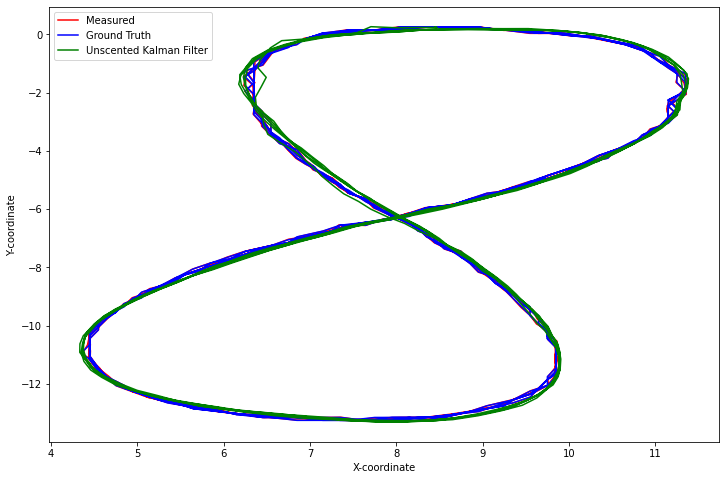

Kalman filter: RMSE in x position= 0.06302147303745405
Kalman filter: RMSE in y position= 0.05952545643404157
Kalman filter: RMSE in vx= 0.6602461686310457
Kalman filter: RMSE in vy= 0.6031333319181349
Measured: RMSE in x position= 0.010290615989870584
Measured: RMSE in y position= 0.010114231551818823


In [5]:
#Process noise parameters
sigma_a2 = 0.5
sigma_psi2 = 1.0
#Measurement noise parameters: Lidar
sigma_x2 = 0.0225
sigma_y2 = 0.0225
#Measurement noise parameters: Radar
sigma_rho2 = 0.09
sigma_phi2 = 0.0009
sigma_rhodot2 = 0.09

useLidar = True
useRadar = False

#initialization
P = np.asarray([[100,0,0,0,0],[0,10,0,0,0],[0,0,100,0,0],[0,0,0,100,0],[0,0,0,0,10]])
X = np.asarray([[0.01],[0.01],[5.0],[0.0],[0.0]])
Q = np.asarray([[sigma_a2,0],[0,sigma_psi2]])

def AngleNorm(theta):
    if theta > np.pi:
        theta = theta - (2*np.pi)
    elif theta > np.pi:
        theta = theta + (2*np.pi)
    return theta

def Polar2Cartesian(arr):
    rho = arr[0]
    angle = arr[1]
    return rho*np.cos(angle),rho*np.sin(angle)

def RMSE(x,xprime):
    return np.linalg.norm(np.asarray(x)-np.asarray(xprime))/np.sqrt(len(x))

def MatrixAugment(A,B):
    nA = A.shape[0]
    nB = B.shape[0]
    T1 = np.concatenate((A,np.zeros([nA,nB])),axis=1)
    T2 = np.concatenate((np.zeros([nB,nA]),B),axis=1)
    return np.concatenate((T1,T2))

def MatrixSquareRoot(M):
    #print(M)
    eigval,V = np.linalg.eig(M)
    S = np.diag(np.abs(eigval))
    D = np.sqrt(S)
    T = np.dot(np.dot(V,D),np.linalg.inv(V))
    #print(S,D)
    return T 
    #U,S,VT = np.linalg.svd(M)
    #D = np.sqrt(np.diag(S))
    #return np.dot(np.dot(U,D),VT)

def NewState(Xa,dt):
    x,y,v,psi,psidot,nua,nupsi = tuple(Xa)
    if abs(psidot) > 0.001:
        xnew = x + (v/psidot)*(np.sin(psi+psidot*dt)-np.sin(psi))+nua*np.cos(psi)*(dt**2)/2
        ynew = y + (v/psidot)*(-np.cos(psi+psidot*dt)+np.cos(psi))+nua*np.sin(psi)*(dt**2)/2
        vnew = v +nua*dt
        psinew = psi+psidot*dt+nupsi*(dt**2)/2
        psidotnew = psidot + nupsi*dt
    else:
        xnew = x + v*np.cos(psi)*dt+nua*np.cos(psi)*(dt**2)/2
        ynew = y + v*np.cos(psi)*dt+nua*np.sin(psi)*(dt**2)/2
        vnew = v +nua*dt
        psinew = psi + nupsi*(dt**2)/2
        psidotnew = psidot + nupsi*dt
    state = np.asarray([xnew,ynew,vnew,psinew,psidotnew])
    return state

def PredMeanandCovariance(A,wts):
    wtmatrix = np.transpose([wts[i]*np.ones(A.shape[0]) for i in range(len(wts))])
    predmean = np.sum(np.multiply(A,wtmatrix),axis=1)
    covmatrix = np.zeros([A.shape[0],A.shape[0]])
    for i in range(A.shape[1]):
        tmp = np.asarray(A[:,i:i+1]-np.reshape(predmean,(A.shape[0],1)))
        if tmp.shape[0] > 3:
            tmp[3] = AngleNorm(tmp[3])
        covmatrix = covmatrix + np.dot(wts[i]*tmp,np.transpose(tmp))
    return predmean,covmatrix

#Lidar
#observes only position
HLidar = np.asarray([[1,0,0,0,0],[0,1,0,0,0]])
#noise covariance
RLidar = np.asarray([[sigma_x2,0],[0,sigma_y2]]) 

#Radar
def CrossCovariance(A,meanA,B,meanB,wts):
    covmatrix = np.zeros([A.shape[0],B.shape[0]])
    mA = np.reshape(meanA,(A.shape[0],1))
    mB = np.reshape(meanB,(B.shape[0],1))
    for i in range(A.shape[1]):
        tmpA = A[:,i:i+1]-mA
        tmpB = B[:,i:i+1]-mB
        covmatrix = covmatrix + np.dot(wts[i]*tmpA,np.transpose(tmpB))
    return covmatrix

def HRadar(state):
    x,y,v,psi,psidot = state
    return np.asarray([math.sqrt(x**2+y**2),math.atan2(y,x),(x*v*np.cos(psi)+y*v*np.sin(psi))/math.sqrt(x**2+y**2)])
#noise covariance
RRadar = np.asarray([[sigma_rho2,0,0],[0,sigma_phi2,0],[0,0,sigma_rhodot2]]) 

    
data=[]
sensortype=[]
#DataFile = open("./obj_pose-laser-radar-synthetic-input.txt","r+")
DataFile = open("./data/sample-laser-radar-measurement-data-1.txt","r+")

for row in DataFile.readlines():
    curRow = []
    if row.split()[0] == 'L':
        sensortype.append("L")
    elif row.split()[0] == 'R':
        sensortype.append("R")
    data.append([float(i) for i in row.split()[1:]])

xpos=[]
ypos=[]
xpos_gt=[]
ypos_gt=[]
vx_gt=[]
vy_gt=[]
v=[]
psi=[]
xpos_measured=[]
ypos_measured = []

prev_timestamp = 1477010442500000.0
Radarstates=3
Lidarstates=2
for idx,Z in enumerate(data): 
    Lidar = (sensortype[idx]=='L')
    if Lidar:
        if useLidar:
            dt = (Z[2] - prev_timestamp)/1000000.0
            #dt = 0.1
            prev_timestamp = Z[2]
            xpos_gt.append(Z[3])
            ypos_gt.append(Z[4])
            vx_gt.append(Z[5])
            vy_gt.append(Z[6])
            xpos_measured.append(Z[0])
            ypos_measured.append(Z[1])
        else:
            continue
    else:
        if useRadar:
            dt = (Z[3] - prev_timestamp)/1000000.0
            #dt = 0.1
            prev_timestamp = Z[3]
            xpos_gt.append(Z[4])
            ypos_gt.append(Z[5])
            vx_gt.append(Z[6])
            vy_gt.append(Z[7])
            xt,yt = Polar2Cartesian(Z[0:2])
            xpos_measured.append(xt)
            ypos_measured.append(yt)
        else:
            continue
   #Prediction step
   #Generate sigma points: (a) matrix square root of augmented covariance matrix
   #(b) non-linear transformation
    Pa = MatrixAugment(P,Q)
    n=Pa.shape[0]
    lam=3
    nanCheck = np.isnan(np.sum(Pa))
    if nanCheck:
        print(idx,nanCheck)  
    PaSqrt = np.sqrt(lam+n)*MatrixSquareRoot(Pa)
    Xa = np.reshape(np.append(X,[0.0,0.0]),(n,1))
    SigmaPoints = Xa
    for i in range(n):
        SigmaPoints= np.append(SigmaPoints,Xa+PaSqrt[:,i:i+1],axis=1)
        SigmaPoints= np.append(SigmaPoints,Xa-PaSqrt[:,i:i+1],axis=1)
    PredictedSigmaPoints = np.transpose(np.asarray([NewState(SigmaPoints[:,i],dt) for i in range(SigmaPoints.shape[1])]))
    weights = np.ones(2*n+1)/(2*(n+lam))
    weights[0]=lam/(n+lam)
    X,P = PredMeanandCovariance(PredictedSigmaPoints,weights)
    #Update step
    if Lidar:
        S=np.matmul(np.matmul(HLidar,P),np.transpose(HLidar))+RLidar
        K = np.dot(np.matmul(P,np.transpose(HLidar)),np.linalg.inv(S))
        y=np.reshape(np.asarray(Z[0:2]),(Lidarstates,1))-np.dot(HLidar,np.reshape(X,(n-2,1)))
        X = np.add(np.reshape(X,(n-2,1)),np.dot(K,y))
        P = np.matmul(np.identity(5)-np.matmul(K,HLidar),P)
        xpos.append(X[0])
        ypos.append(X[1])
        v.append(X[2])
        psi.append(X[3])
    else:
        MeasuredSigmaPoints = np.transpose(np.asarray([HRadar(PredictedSigmaPoints[:,i]) for i in range(SigmaPoints.shape[1])]))
        Zprime,S = PredMeanandCovariance(MeasuredSigmaPoints,weights)
        S = np.add(S,RRadar)
        Pxz = CrossCovariance(PredictedSigmaPoints,X,MeasuredSigmaPoints,Zprime,weights)
        K = np.dot(Pxz,np.linalg.inv(S))
        y = np.reshape(Zprime,(Radarstates,1))
        if y[1] > np.pi:
            y[1] = y[1]-2*np.pi
        elif y[1] < -np.pi:
            y[1] = y[1]+2*np.pi        
        y = np.reshape(np.asarray(Z[0:3]),(Radarstates,1))-y
        X = np.add(np.reshape(X,(n-2,1)),np.dot(K,y))
        P = P - np.dot(np.dot(K,S),np.transpose(K))
        xpos.append(X[0])
        ypos.append(X[1])
        v.append(X[2])
        psi.append(X[3])
    eig,_=np.linalg.eig(P)  
    if np.min(eig)<0:
        print(idx)
xpos = list(itertools.chain.from_iterable(xpos))
ypos = list(itertools.chain.from_iterable(ypos))
v = np.asarray(list(itertools.chain.from_iterable(v)))
psi = np.asarray(list(itertools.chain.from_iterable(psi)))
vx = np.multiply(v,np.cos(psi))
vy = np.multiply(v,np.sin(psi))
plt.figure(figsize=(12,8))
plt.plot(xpos_measured,ypos_measured,label='Measured',color='r')
plt.plot(xpos_gt,ypos_gt,label='Ground Truth',color='b')
plt.plot(xpos,ypos,label='Unscented Kalman Filter',color='g')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.savefig('UKF.png',bbox_inches='tight')
plt.show()


print("Kalman filter: RMSE in x position=",RMSE(xpos,xpos_gt))
print("Kalman filter: RMSE in y position=",RMSE(ypos,ypos_gt))
print("Kalman filter: RMSE in vx=",RMSE(vx,vx_gt))
print("Kalman filter: RMSE in vy=",RMSE(vy,vy_gt))

print("Measured: RMSE in x position=",RMSE(xpos_measured,xpos_gt))
print("Measured: RMSE in y position=",RMSE(ypos_measured,ypos_gt))

In [ ]:
import pandas as pd
data=[]
DataFile = open("./obj_pose-laser-radar-synthetic-input.txt","r+")
for row in DataFile.readlines():
    curRow = []
    if row.split()[0] == 'L':
        data.append([float(i) for i in row.split()[1:]])
headers=["xmeas", "ymeas","timestamp", "x_gt", "y_gt", "vx_gt","vy_gt","yaw_gt","yawrate_gt"]
df = pd.DataFrame(data, columns=headers)
print(df.head())

In [9]:
arr = np.asarray([[2,1],[-1,7]])
val,eigmat = np.linalg.eig(arr)
S=np.diag(val)
print(S)
D=np.sqrt(S)
print(D)
print(np.dot(np.dot(eigmat,np.diag(val)),np.linalg.inv(eigmat)))

[[2.20871215 0.        ]
 [0.         6.79128785]]
[[1.48617366 0.        ]
 [0.         2.60600995]]
[[ 2.  1.]
 [-1.  7.]]
